In [22]:
import torch
import numpy as np
import gymnasium as gym

import sys
sys.path.append('../../..')
from tools.trainer import Trainer
from tools.logger import Logger
from environments.hockey_wrapper import HockeyWrapper
from TD3 import TD3Agent
import laserhockey.hockey_env as h_env

In [2]:
env_string = "Hockey"

In [3]:
if env_string == "Hockey":
    env = HockeyWrapper(mode="normal", opponent="strong")
else:
    env = gym.make(env_string)

In [4]:
agent = TD3Agent(env.observation_space, env.action_space)
trainer = Trainer()

In [5]:
ep_rewards = trainer.train(env, agent, n_episodes=30000, test_every=100, noise=0.4)

Step 101/30000:
                    test reward: -31.68
                    mean reward: -28.37, max reward: 9.64
                    Avg. step count: 193.3, Avg ep duration: 0.076s
                    Avg. critic loss: 0.03, Avg. actor loss: 0.25
                    Avg. train duration: 0.333s
                    winrate: 0.05, drawrate: 0.75, lossrate: 0.20
            
Step 201/30000:
                    test reward: -28.90
                    mean reward: -30.12, max reward: 6.34
                    Avg. step count: 189.3, Avg ep duration: 0.074s
                    Avg. critic loss: 0.02, Avg. actor loss: 0.32
                    Avg. train duration: 0.332s
                    winrate: 0.05, drawrate: 0.70, lossrate: 0.22
            
Step 301/30000:
                    test reward: -28.50
                    mean reward: -27.34, max reward: 7.81
                    Avg. step count: 200.7, Avg ep duration: 0.075s
                    Avg. critic loss: 0.02, Avg. actor loss: 0.46
  

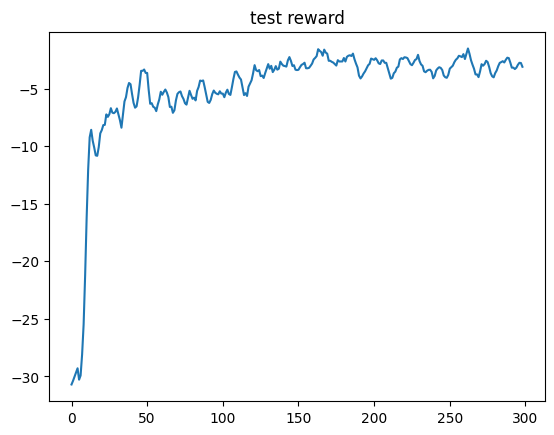

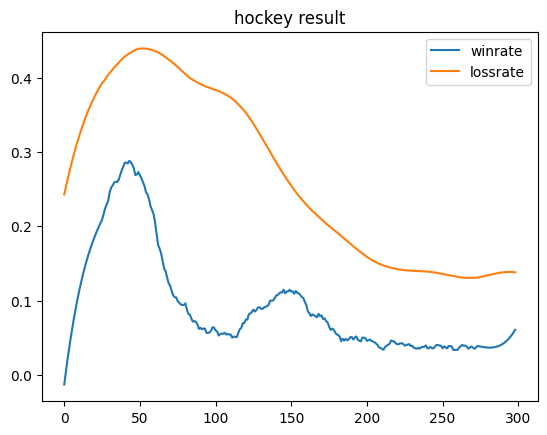

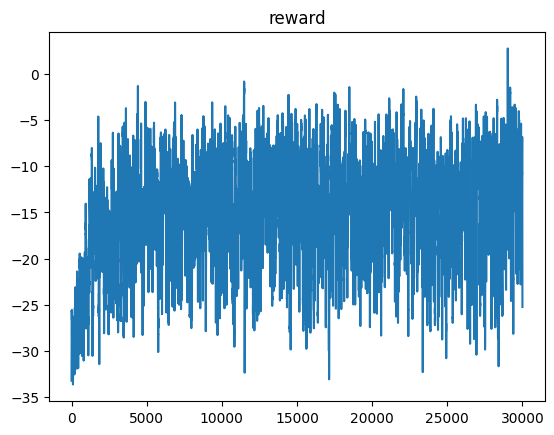

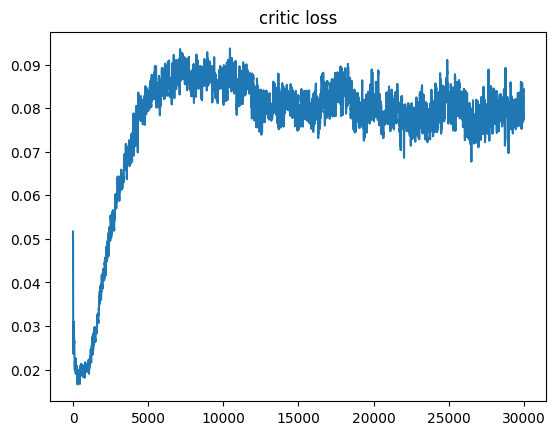

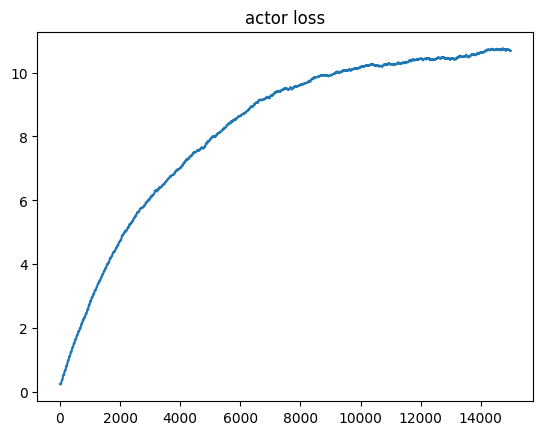

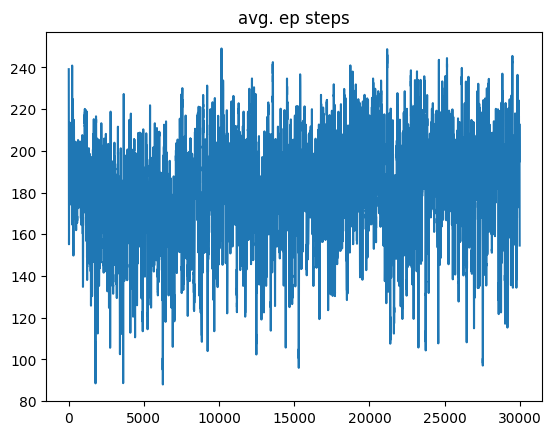

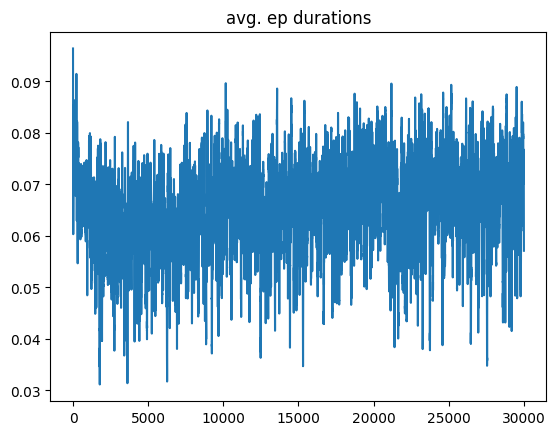

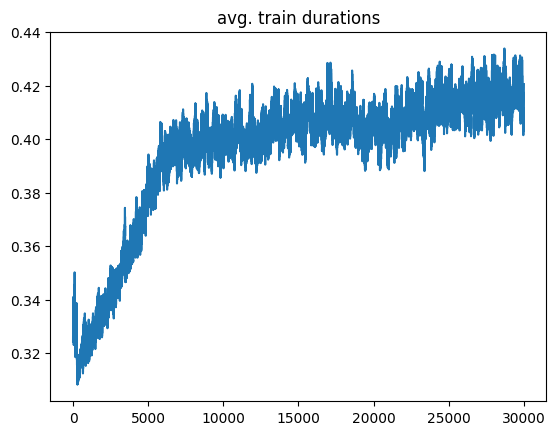

In [12]:
trainer.logger.plot()

In [23]:
def play(env_string, agent, n_episodes=10, noise=0):
    if env_string == 'Hockey':
        env = HockeyWrapper(mode='normal', opponent='weak')
        render = True
    else:
        env = gym.make(env_string, render_mode='human')
        render = False
    opp = h_env.BasicOpponent(weak=False)
    steps, rewards, observations, actions, results = Trainer.run(env, opp, n_episodes=n_episodes, noise=noise, render=True, store_transitions=False, hockey=env_string=='Hockey')
    env.close()
    return steps, rewards, observations, actions, results

In [26]:
steps, rewards, observations, actions, results = play(env_string, agent, n_episodes=5, noise=0)
print(np.mean(rewards))

1.2491836065491053


In [9]:
trainer.logger.save("logs/pendulum_td3.npy")

In [10]:
# torch.save(agent.state(), 'checkpoint_hockey.pth')

In [11]:
# agent_state = torch.load('checkpoint_hockey.pth')
# agent.restore_state(agent_state)